**Installing packages**

In [1]:
import os, json, re
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from openai import OpenAI
from google.colab import files

In [2]:
# Upload/Download Helpers
def upload_one_file(expected_ext = None):
  uploaded = files.upload()
  fname = list(uploaded.keys())[0]
  if expected_ext and not fname.lower().endswith(expected_ext):
    raise ValueError(f"Expected {expected_ext} file, got {fname}")
  return fname

def download_file(fname):
  files.download(fname)

In [3]:
from google.colab import userdata
import os
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
client = OpenAI()

**Upload Email csv file**

In [4]:
csv_file = upload_one_file(".csv")
df = pd.read_csv(csv_file)
print(df.shape)
df.head()


Saving email_campaigns_synth_780.csv to email_campaigns_synth_780 (3).csv
(780, 11)


,campaign_id,send_date,audience_segment,tone_seed,subject,preheader,body_text,open_rate,click_rate,unsubscribe_rate,category_seed
0,cmp_b7f4ccc86c,2023-05-23,US,informational,New insights on PMAX,Search & performance insights for US teams,This email explores Search & performance with ...,0.2849,0.0333,0.00315,Search & performance
1,cmp_f57b010b9c,2023-02-02,Enterprise,informational,What’s changing in SEARCH,Search & performance insights for Enterprise t...,This email explores Search & performance with ...,0.3057,0.0342,0.00227,Search & performance
2,cmp_92d1ba18e7,2023-01-28,EMEA,informational,Key trends in AUTOMATION you should know,AI marketing insights for EMEA teams,This email explores AI marketing with a focus ...,0.3174,0.0492,0.00203,AI marketing
3,cmp_ced176138c,2024-08-26,Enterprise,thought_leadership,A new perspective on LIFECYCLE,App growth insights for Enterprise teams,This email explores App growth with a focus on...,0.2563,0.0244,0.00203,App growth
4,cmp_583bd98902,2023-06-09,EMEA,informational,What’s changing in CANNES,Brand & creative insights for EMEA teams,This email explores Brand & creative with a fo...,0.2773,0.0120,0.00078,Brand & creative


**Build Model**

In [5]:
def build_model_text(row):
    return f"""
SUBJECT: {row['subject']}
PREHEADER: {row.get('preheader','')}
BODY: {row['body_text']}
SEGMENT: {row['audience_segment']}
""".strip()

df["model_text"] = df.apply(build_model_text, axis=1)


In [6]:
# Embeddings (batched)
def embed_texts(texts, batch_size=200, model="text-embedding-3-small"):
    vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        resp = client.embeddings.create(model=model, input=batch)
        vecs.extend([d.embedding for d in resp.data])
    return np.array(vecs, dtype=np.float32)

X = embed_texts(df["model_text"].tolist(), batch_size=200)
print(X.shape)


(780, 1536)


In [7]:
# Clustering
N_CLUSTERS = 8
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init="auto")
df["cluster_id"] = kmeans.fit_predict(X)
df["cluster_id"].value_counts()


,count
cluster_id,
0,142
1,135
2,123
3,118
6,111
7,69
5,54
4,28


In [8]:
# Robust JSON Utilities
def extract_json_object(text):
    if not text or not str(text).strip():
        raise ValueError("Empty response")

    text = str(text).strip()
    text = re.sub(r"^```(?:json)?\s*", "", text)
    text = re.sub(r"\s*```$", "", text)

    try:
        return json.loads(text)
    except Exception:
        pass

    start, end = text.find("{"), text.rfind("}")
    if start != -1 and end != -1 and end > start:
        return json.loads(text[start:end+1])

    raise ValueError(f"JSON parse failed: {text[:200]}")


In [9]:
# Cluster Labeling (LLM)
def label_cluster(cluster_texts):
    sample = "\n\n---\n\n".join(cluster_texts[:10])

    prompt = f"""
Return ONLY valid JSON with keys:
- theme_label (3–6 words)
- tone (informational | thought_leadership | promotional | how_to | case_study | mixed)
- audience_intent (learn | compare | act | explore | be_inspired | mixed)
- summary (2–3 sentences)

EMAIL EXAMPLES:
{sample}
""".strip()

    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role":"system","content":"Return ONLY JSON. No extra text."},
            {"role":"user","content":prompt},
        ],
        temperature=0.2
    )

    raw = resp.choices[0].message.content
    try:
        parsed = extract_json_object(raw)
    except Exception:
        repair = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role":"system","content":"Return ONLY JSON. No extra text."},
                {"role":"user","content":f"Fix into valid JSON:\n{raw}"},
            ],
            temperature=0.0
        )
        parsed = extract_json_object(repair.choices[0].message.content)

    parsed.setdefault("theme_label","Theme Cluster")
    parsed.setdefault("tone","mixed")
    parsed.setdefault("audience_intent","mixed")
    parsed.setdefault("summary","Summary unavailable")

    return parsed


In [11]:
print("df rows:", len(df))
print("cluster_id exists?", "cluster_id" in df.columns)
if "cluster_id" in df.columns:
    print("unique clusters:", df["cluster_id"].nunique())
    print(df["cluster_id"].value_counts().head())


df rows: 780
cluster_id exists? True
unique clusters: 8
cluster_id
0    142
1    135
2    123
3    118
6    111
Name: count, dtype: int64


In [12]:
# Build Cluster Results
cluster_results = {}

for cid in sorted(df["cluster_id"].unique()):
    cluster_df = df[df["cluster_id"] == cid]
    labels = label_cluster(cluster_df["model_text"].tolist())

    cluster_results[cid] = {
        "theme_label": labels["theme_label"],
        "tone": labels["tone"],
        "audience_intent": labels["audience_intent"],
        "summary": labels["summary"],
        "n_campaigns": int(len(cluster_df)),
        "avg_open_rate": round(float(cluster_df["open_rate"].mean()), 4),
        "avg_click_rate": round(float(cluster_df["click_rate"].mean()), 4),
        "avg_unsubscribe_rate": round(float(cluster_df["unsubscribe_rate"].mean()), 5),
    }

print("cluster_results built for", len(cluster_results), "clusters")
print("Example:", next(iter(cluster_results.items())))


cluster_results built for 8 clusters
Example: (np.int32(0), {'theme_label': 'Insights on PMAX and Bidding', 'tone': 'informational', 'audience_intent': 'learn', 'summary': 'This email provides insights into PMAX and bidding strategies, focusing on their impact on marketing effectiveness. It is tailored for audiences across various regions, including US, EMEA, and APAC, aiming to enhance their understanding of current trends.', 'n_campaigns': 142, 'avg_open_rate': 0.2721, 'avg_click_rate': 0.0335, 'avg_unsubscribe_rate': 0.00256})


In [13]:
# Recommendations per Cluster
def cluster_recommendations(theme, summary, perf):
    prompt = f"""
Theme: {theme}
Summary: {summary}

Performance:
open={perf['avg_open_rate']}
click={perf['avg_click_rate']}
unsubscribe={perf.get('avg_unsubscribe_rate')}

Return ONLY JSON with:
- subject_line_ideas (5)
- content_improvements (5)
- measurement_notes (3)
""".strip()

    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role":"system","content":"Return ONLY JSON. No extra text."},
            {"role":"user","content":prompt},
        ],
        temperature=0.4
    )

    raw = resp.choices[0].message.content
    try:
        return extract_json_object(raw)
    except Exception:
        repair = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role":"system","content":"Return ONLY JSON. No extra text."},
                {"role":"user","content":f"Fix into valid JSON:\n{raw}"},
            ],
            temperature=0.0
        )
        return extract_json_object(repair.choices[0].message.content)

for cid in cluster_results:
    info = cluster_results[cid]
    info["recommendations"] = cluster_recommendations(info["theme_label"], info["summary"], info)

print("Recommendations added")


Recommendations added


In [14]:
# Attaching AI labels back to rows
df["ai_theme"] = df["cluster_id"].map({k:v["theme_label"] for k,v in cluster_results.items()})
df["ai_tone"] = df["cluster_id"].map({k:v["tone"] for k,v in cluster_results.items()})
df["ai_audience_intent"] = df["cluster_id"].map({k:v["audience_intent"] for k,v in cluster_results.items()})
df["ai_theme_summary"] = df["cluster_id"].map({k:v["summary"] for k,v in cluster_results.items()})
df.head()

,campaign_id,send_date,audience_segment,tone_seed,subject,preheader,body_text,open_rate,click_rate,unsubscribe_rate,category_seed,model_text,cluster_id,ai_theme,ai_tone,ai_audience_intent,ai_theme_summary
0,cmp_b7f4ccc86c,2023-05-23,US,informational,New insights on PMAX,Search & performance insights for US teams,This email explores Search & performance with ...,0.2849,0.0333,0.00315,Search & performance,SUBJECT: New insights on PMAX\nPREHEADER: Sear...,0,Insights on PMAX and Bidding,informational,learn,This email provides insights into PMAX and bid...
1,cmp_f57b010b9c,2023-02-02,Enterprise,informational,What’s changing in SEARCH,Search & performance insights for Enterprise t...,This email explores Search & performance with ...,0.3057,0.0342,0.00227,Search & performance,SUBJECT: What’s changing in SEARCH\nPREHEADER:...,0,Insights on PMAX and Bidding,informational,learn,This email provides insights into PMAX and bid...
2,cmp_92d1ba18e7,2023-01-28,EMEA,informational,Key trends in AUTOMATION you should know,AI marketing insights for EMEA teams,This email explores AI marketing with a focus ...,0.3174,0.0492,0.00203,AI marketing,SUBJECT: Key trends in AUTOMATION you should k...,3,Key trends in automation,informational,learn,"This email explores key trends in automation, ..."
3,cmp_ced176138c,2024-08-26,Enterprise,thought_leadership,A new perspective on LIFECYCLE,App growth insights for Enterprise teams,This email explores App growth with a focus on...,0.2563,0.0244,0.00203,App growth,SUBJECT: A new perspective on LIFECYCLE\nPREHE...,2,Insights on App Growth Strategies,informational,learn,This email series provides insights into vario...
4,cmp_583bd98902,2023-06-09,EMEA,informational,What’s changing in CANNES,Brand & creative insights for EMEA teams,This email explores Brand & creative with a fo...,0.2773,0.0120,0.00078,Brand & creative,SUBJECT: What’s changing in CANNES\nPREHEADER:...,1,Insights on Cannes and Storytelling,informational,learn,This email provides insights into the evolving...


**Save + Download Outputs**

In [15]:
enriched_file = "email_campaigns_enriched_ai.csv"
summary_file = "cluster_summary_ai.json"

df.to_csv(enriched_file, index=False)
with open(summary_file, "w") as f:
    json.dump({str(k): v for k,v in cluster_results.items()}, f, indent=2)

download_file(enriched_file)
download_file(summary_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Visualizations**

**Theme Performance**

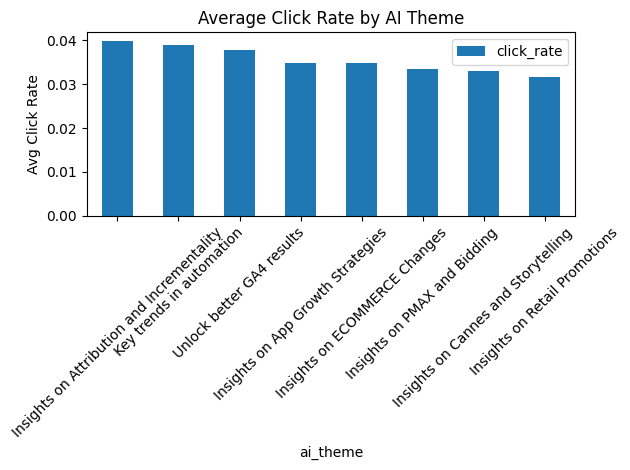

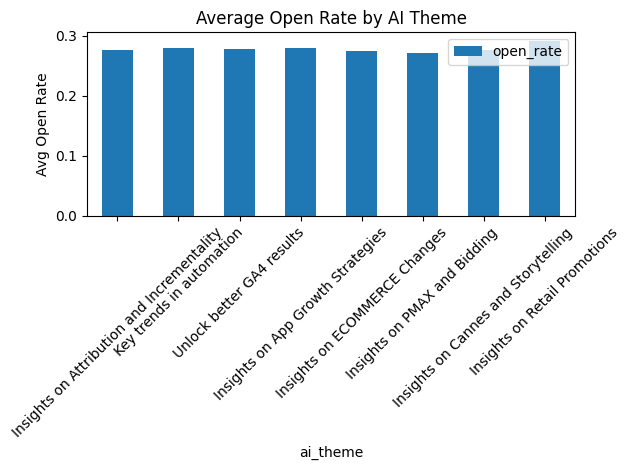

In [16]:
import matplotlib.pyplot as plt

theme_perf = (
    df.groupby("ai_theme", dropna=False)[["open_rate","click_rate","unsubscribe_rate"]]
      .mean()
      .sort_values("click_rate", ascending=False)
)

theme_perf[["click_rate"]].plot(kind="bar", rot=45)
plt.title("Average Click Rate by AI Theme")
plt.ylabel("Avg Click Rate")
plt.tight_layout()
plt.show()

theme_perf[["open_rate"]].plot(kind="bar", rot=45)
plt.title("Average Open Rate by AI Theme")
plt.ylabel("Avg Open Rate")
plt.tight_layout()
plt.show()


**Bubble Chart: Open vs Click**

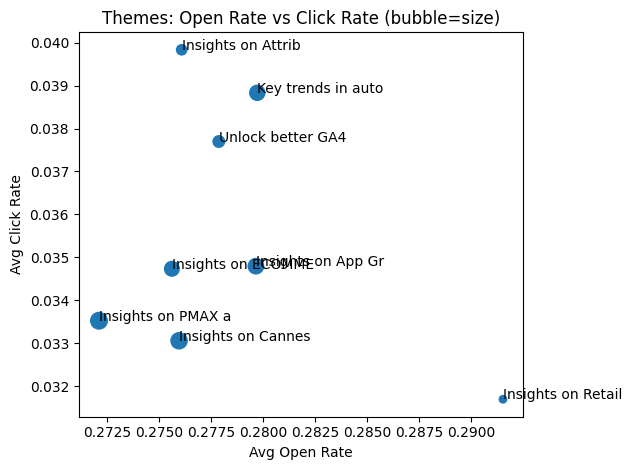

In [19]:
import matplotlib.pyplot as plt

theme_counts = df.groupby("ai_theme").size().rename("n_campaigns")
theme_perf2 = theme_perf.join(theme_counts)

plt.figure()
plt.scatter(theme_perf2["open_rate"], theme_perf2["click_rate"], s=theme_perf2["n_campaigns"])
for theme, r in theme_perf2.iterrows():
    plt.text(r["open_rate"], r["click_rate"], str(theme)[:18])
plt.title("Themes: Open Rate vs Click Rate (bubble=size)")
plt.xlabel("Avg Open Rate")
plt.ylabel("Avg Click Rate")
plt.tight_layout()
plt.show()


**Heatmap: segment × theme (avg click rate)**

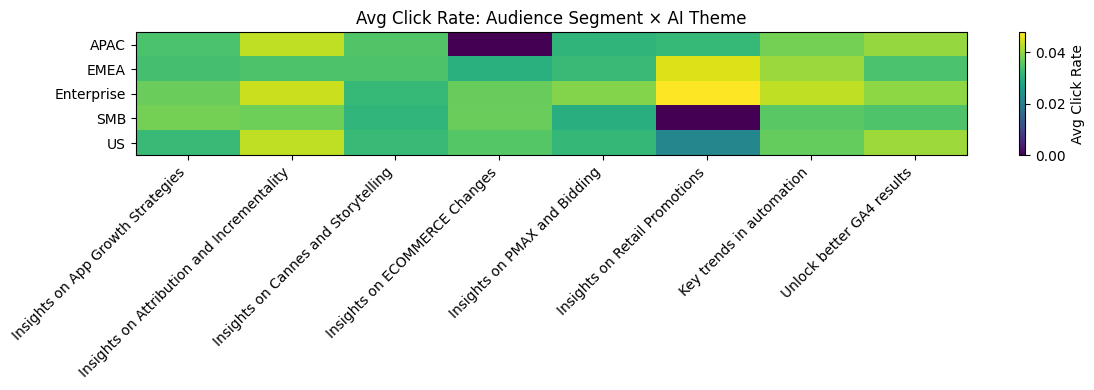

In [20]:
import matplotlib.pyplot as plt

pivot = df.pivot_table(
    index="audience_segment",
    columns="ai_theme",
    values="click_rate",
    aggfunc="mean"
).fillna(0)

plt.figure(figsize=(12,4))
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha="right")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Avg Click Rate: Audience Segment × AI Theme")
plt.colorbar(label="Avg Click Rate")
plt.tight_layout()
plt.show()


**Trend over time (monthly click rate)**

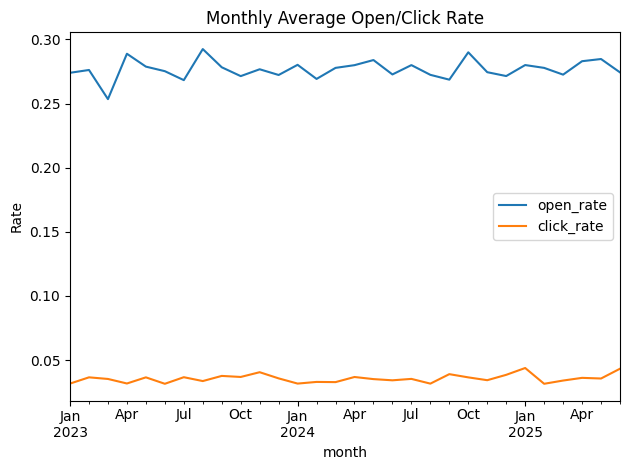

In [21]:
import matplotlib.pyplot as plt

df["send_date"] = pd.to_datetime(df["send_date"])
df["month"] = df["send_date"].dt.to_period("M").dt.to_timestamp()

monthly = df.groupby("month")[["open_rate","click_rate"]].mean()

monthly.plot()
plt.title("Monthly Average Open/Click Rate")
plt.ylabel("Rate")
plt.tight_layout()
plt.show()


**Theme share over time**

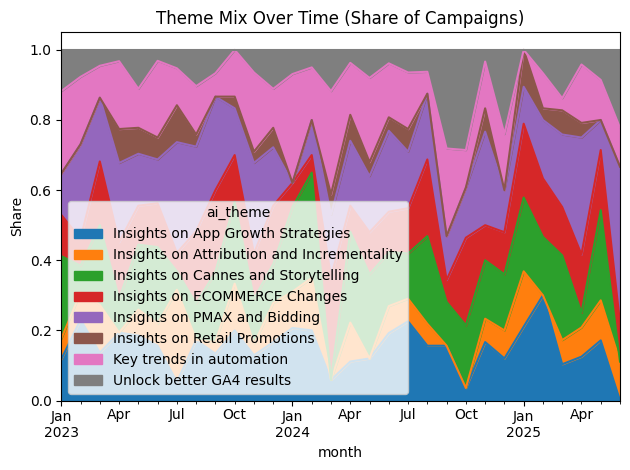

In [22]:
import matplotlib.pyplot as plt

theme_share = (
    df.groupby(["month","ai_theme"]).size()
      .reset_index(name="n")
      .pivot(index="month", columns="ai_theme", values="n")
      .fillna(0)
)

theme_share = theme_share.div(theme_share.sum(axis=1), axis=0)

theme_share.plot(kind="area", stacked=True)
plt.title("Theme Mix Over Time (Share of Campaigns)")
plt.ylabel("Share")
plt.tight_layout()
plt.show()
